# Analyze Xpol from binned analysis

### Mar 25, 2021

## Code

In [1]:
import sys
import csv
# sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
# import ROOT
import math
import numpy as np
# from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib as mpl
import matplotlib.pyplot as plt
# from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import pyrex
import seaborn as sns
%matplotlib inline
sys.path.insert(1, "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes")
# import deDisperse_util as util
# from pyrex.internal_functions import normalize
my_path_plots = os.path.abspath("./plots/")
# import pyrex.custom.ara as ara



from uncertainties import ufloat
from uncertainties import unumpy


In [2]:
# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")

# Soft triggers distribution

In [3]:
wf = pd.read_pickle("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/ARA_Reconstruction/DPulsePower_run012559.pkl")
wf = wf.loc[wf.theta_reco>=90]
#   = pd.read_pickle("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/ARA_Reconstruction/PowerNoise_softTriggers_run012559_newCalib.pkl")

### Add interpolated depth to df

In [4]:
depth_1224 = pd.read_csv("./plots/SpiceCorePolReco/A2_1224Depth.txt")
time = pd.to_datetime(depth_1224.NZ_Time)
# time = time.reindex(time)
# time = time.tz_localize('NZ').tz_convert("UTC")
time.head()
newTime = time.apply(lambda dt: dt.replace(day=24, month = 12, year = 2018))
# newTime#Still in NZ local time. Need to translate to UTC
df = pd.DataFrame(1, index=newTime, columns=['X'])
import pytz
nz = pytz.timezone('NZ')
utc = pytz.timezone('UTC')
df.index = df.index.tz_localize(nz).tz_convert(utc)
unixTimeDepth = (df.index - pd.Timestamp("1970-01-01").tz_localize(utc)) // pd.Timedelta('1s')#This is unix time 

In [5]:
f = scipy.interpolate.interp1d(unixTimeDepth, depth_1224.depth,bounds_error=False, fill_value=0.)
wf = wf.loc[(wf.unixTime>min(wf.unixTime)) & (wf.unixTime<2.15*1E4+1.5456*1E9)]
# softWf = softWf.loc[(softWf.unixTime>min(wf.unixTime)) & (softWf.unixTime<2.15*1E4+1.5456*1E9)]

interp_depth = f(wf.unixTime)
# interp_depthSoft = f(softWf.unixTime)

wf["interp_depth"] = interp_depth
# softWf["interp_depth"] = interp_depthSoft

In [6]:
def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

def rotatePolVector(launchVecSrc, recVec, PolVecAntenna):
    recVec = -recVec #receiving vector needs to be reflected, otherwise rotation matrix will be off by pi
    newPol = np.dot(PolVecAntenna,rotation_matrix_from_vectors(launchVecSrc,recVec))
    return newPol

def Rx(theta):
    return np.matrix([[ 1, 0           , 0           ],
                   [ 0, np.cos(theta),-np.sin(theta)],
                   [ 0, np.sin(theta), np.cos(theta)]])

In [7]:
def estimatePolRayTracer(depth):
    #Take depth of pulser and calculate polarization rotation based on raytracer results.
    rt = pyrex.RayTracer(from_point=(0, 0, -depth), to_point=(2400, 0, -179.93)) #Use the depth of the transmitter as the z-
    #coordinate. A2 is at a horizontal distance of 2400 m from the pulser, and at a depth of 179.93 m
    path = rt.solutions[0] #We only care about direct solutions
    rotMat = rotation_matrix_from_vectors(path.received_direction,path.emitted_direction)
    initPulserPol = np.array([0,0,1])
#     initPulserPol = np.array([np.sqrt(0.25/2),np.sqrt(0.25/2),np.sqrt(0.75)])
    rotAngle = np.pi/2-np.arccos(path.emitted_direction[2])
#     pulserPol = np.array(np.matmul(initPulserPol,Rx(rotAngle)))[0]
    rotatedPol = np.dot(initPulserPol,rotMat)
    newOmegaPol = np.degrees(np.arccos(rotatedPol[2]))
    polFinal = newOmegaPol-np.degrees(rotAngle)
    return polFinal, np.degrees(rt.solutions[0].theta0), 180-np.degrees(np.arccos(path.received_direction[2]))

def estimateRecAngle(depth):
    #Take depth of pulser and calculate the receiving angle at the antenna
    rt = pyrex.RayTracer(from_point=(0, 0, -depth), to_point=(2400, 0, -179.93)) #Use the depth of the transmitter as the z-
    #coordinate. A2 is at a horizontal distance of 2400 m from the pulser, and at a depth of 179.93 m
    path = rt.solutions[0] #We only care about direct solutions
    return 180-np.degrees(np.arccos(path.received_direction[2]))

### Average waveforms over certain depth

In [10]:
plt.figure(figsize=(8,5))

avgArray = []
depthArr = []
recAng = []
# errorArr = []
# errorArr2 = []
increase = 20 # average waveoform values every 20 m
for depth in range(600,1000,increase):
    depthWf = wf.loc[(wf.interp_depth>=depth) & (wf.interp_depth<(depth+increase))]
    depthWf = depthWf.drop(columns=['evNum','theta_reco', 'phi_reco', 'unixTime', 'interp_depth', 'times'])
    if(len(depthWf)==0):
        continue
#     errorArr.append(depthWf["ch2Wf"].std())
#     errorArr2.append(depthWf["ch10Wf"].std())
    avg = []
    for column in depthWf.columns:
        avg.append(unumpy.uarray(np.array(depthWf["%s"%column].mean()),depthWf["%s"%column].std()))
    avgArray.append(avg)
    depthArr.append(depth)
    tracerArray = estimatePolRayTracer(depth+increase/2)
    recAng.append((tracerArray[2]))
#     plt.hist(depthWf["ch2Wf"], bins =20, alpha = 0.5, label = "%i"%depth);
avgWf = pd.DataFrame(avgArray, columns = [*depthWf.columns])
avgWf["depth"] = depthArr
avgWf["recAng"] = recAng
# avgWf["error"] = errorArr
# avgWf["error2"] = errorArr2

# plt.legend()
# plt.xlabel("Vpol power")
avgWf = avgWf.dropna()

<Figure size 576x360 with 0 Axes>

In [11]:
noisePowerChan = np.array([ 198948.83237201,  618793.94802602,  741895.28129648,
        272935.49802384,  324209.48699648,  208490.58954556,
        641412.61161848,  341862.21483048,  986471.80705882,
        608865.14894156,  710127.49137097,  551354.39763633,
        691066.29589686,  360988.99495955,  834482.5863635 ,
       2020906.83550409])

In [12]:
from uncertainties import ufloat #uncertainties package
from uncertainties import unumpy


def getPsi(R):
#     theta = np.radians(theta)
#     phi = np.radians(phi)
#     numerator = np.cos(theta)*np.sin(phi)+R*np.cos(phi)
#     denominator = np.cos(theta)*np.cos(phi)-R*np.sin(phi)
    return unumpy.degrees(unumpy.arctan(R))

def getOmega(theta, R):
#     R = ufloat(R, sigmaR)
    theta = np.radians(theta)
    numerator = np.sin(theta)
    denominator = unumpy.sqrt(1+R**2)
    return unumpy.degrees(unumpy.arccos(numerator/denominator))

def getR(powH, powH_noise, powV, powV_noise, chi):
    Rmeas = unumpy.sqrt((powH-powH_noise)/(powV-powV_noise))
    return unumpy.sqrt((1-chi)*Rmeas**2-chi)

def getDenom(powV):
    denominator = powV
    return denominator


### Omega

Error
2
Error
3
Error
4
Error
6


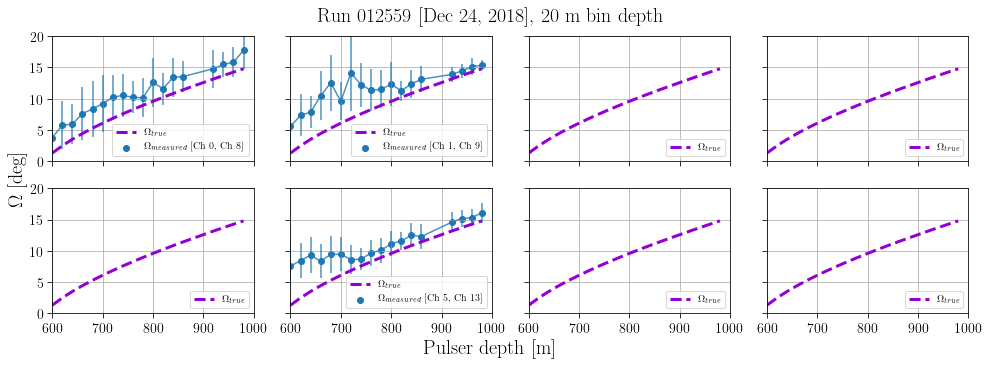

In [34]:
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row', figsize=(14,5))
axs = ax.ravel()

# avgWf.drop(columns=['depth', 'recAng'])
# avgWf.columns[8:]
ch = 0
for a,b in zip(avgWf.columns[:7], avgWf.columns[8:]):
#     print(a,b)
    try:
        values = unumpy.nominal_values(getOmega(avgWf.recAng,getR(avgWf["%s"%b]/noisePowerChan[ch+8],noisePowerChan[ch+8]/noisePowerChan[ch+8],avgWf["%s"%a]/noisePowerChan[ch],noisePowerChan[ch]/noisePowerChan[ch],0.006)))
        errors = unumpy.std_devs(getOmega(avgWf.recAng,getR(avgWf["%s"%b]/noisePowerChan[ch+8],noisePowerChan[ch+8]/noisePowerChan[ch+8],avgWf["%s"%a]/noisePowerChan[ch],noisePowerChan[ch]/noisePowerChan[ch],0)))
        axs[ch].scatter(avgWf.depth, values,label = "$\Omega_{measured}$ [Ch %i, Ch %i]"%(ch,ch+8))
        axs[ch].errorbar(avgWf.depth,values, yerr=errors,alpha = 0.8)

    except:
        print("Error")
        print(ch)
        ch+=1
        continue
    ch+=1
for ax in axs:
#     ax.set_xlabel("a")
    ax.set_xlim(600,1000)
    ax.set_ylim(0,20)
    ax.set(xlabel="", ylabel = "")
    ax.plot(avgWf.depth, getOmega(avgWf.recAng,0),"--",lw=3,c ="darkviolet", label = "$\Omega_{true}$")
    ax.grid()

    ax.legend(loc="lower right", fontsize=10)

fig.text(0.5, 0.03, 'Pulser depth [m]', ha='center', va='center', fontsize=20) 
fig.text(0.03, 0.5, '$\Omega$ [deg]', ha='center', va='center', rotation='vertical', fontsize=20)
plt.suptitle("Run 012559 [Dec 24, 2018], 20 m bin depth", fontsize=20)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
# plt.savefig(my_path_plots+'/SpiceCorePolReco/SpiceCoreOmegaBinned_run012559.png', dpi=250)


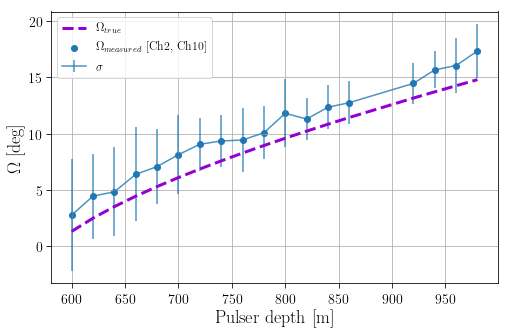

In [25]:
plt.figure(figsize=(8,5))
values = unumpy.nominal_values(getOmega(avgWf.recAng,getR(avgWf.ch10Wf/noisePowerChan[10],noisePowerChan[10]/noisePowerChan[10],avgWf.ch2Wf/noisePowerChan[2],noisePowerChan[2]/noisePowerChan[2],0)))
errors = unumpy.std_devs(getOmega(avgWf.recAng,getR(avgWf.ch10Wf/noisePowerChan[10],noisePowerChan[10]/noisePowerChan[10],avgWf.ch2Wf/noisePowerChan[2],noisePowerChan[2]/noisePowerChan[2],0)))
plt.scatter(avgWf.depth, values,label = "$\Omega_{measured}$ [Ch2, Ch10]")
# plt.plot(avgWf.depth, getOmega(avgWf.recAng,np.sqrt(unumpy.nominal_values(1/(-1+avgWf.ch2Wf/noisePowerChan[2])))),"--",lw=3,c ="darkviolet", label = "$\Omega_{true}$")
plt.plot(avgWf.depth, getOmega(avgWf.recAng,0),"--",lw=3,c ="darkviolet", label = "$\Omega_{true}$")

plt.errorbar(avgWf.depth,values, yerr=errors,alpha = 0.8, label = '$\sigma$')
plt.xlabel('Pulser depth [m]')
plt.ylabel('$\Omega$ [deg]')
plt.legend()
plt.grid()

## Psi

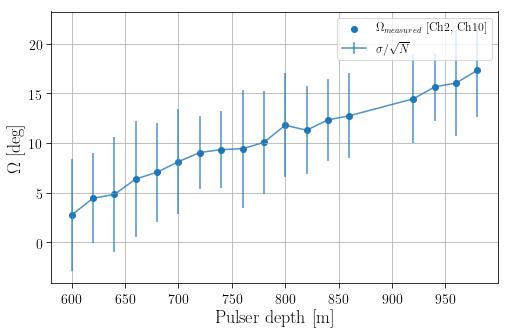

In [51]:
plt.figure(figsize=(8,5))
values = unumpy.nominal_values(getOmega(avgWf.recAng,getR(avgWf.ch10Wf/noisePowerChan[10],noisePowerChan[10]/noisePowerChan[10],avgWf.ch2Wf/noisePowerChan[2],noisePowerChan[2]/noisePowerChan[2],0)))
errors = unumpy.std_devs(getPsi(getR(avgWf.ch10Wf/noisePowerChan[10],noisePowerChan[10]/noisePowerChan[10],avgWf.ch2Wf/noisePowerChan[2],noisePowerChan[2]/noisePowerChan[2],0)))
plt.scatter(avgWf.depth, values,label = "$\Omega_{measured}$ [Ch2, Ch10]")

plt.errorbar(avgWf.depth,values, yerr=errors,alpha = 0.8, label = '$\sigma/\sqrt{N}$')
plt.xlabel('Pulser depth [m]')
plt.ylabel('$\Omega$ [deg]')
plt.legend()
plt.grid()

No handles with labels found to put in legend.


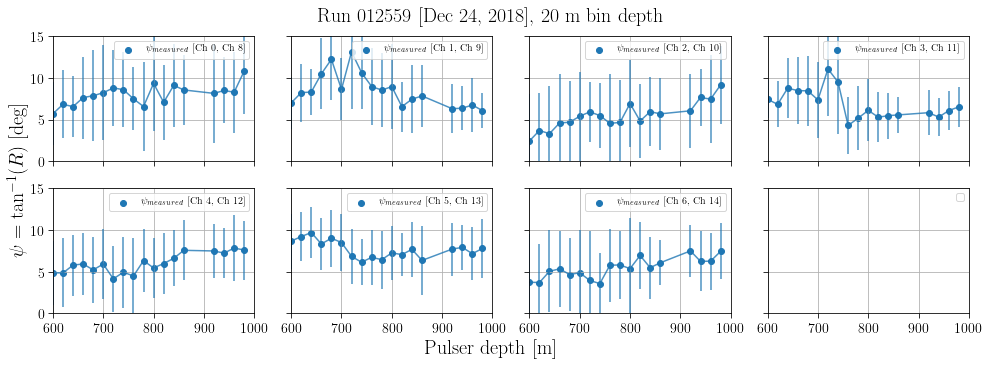

In [91]:
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row', figsize=(14,5))
axs = ax.ravel()

# avgWf.drop(columns=['depth', 'recAng'])
# avgWf.columns[8:]
ch = 0
for a,b in zip(avgWf.columns[:7], avgWf.columns[8:]):
#     print(a,b)
    try:
        values = unumpy.nominal_values(getPsi(getR(avgWf["%s"%b]/noisePowerChan[ch+8],noisePowerChan[ch+8]/noisePowerChan[ch+8],avgWf["%s"%a]/noisePowerChan[ch],noisePowerChan[ch]/noisePowerChan[ch],0)))
        errors = unumpy.std_devs(getPsi(getR(avgWf["%s"%b]/noisePowerChan[ch+8],noisePowerChan[ch+8]/noisePowerChan[ch+8],avgWf["%s"%a]/noisePowerChan[ch],noisePowerChan[ch]/noisePowerChan[ch],0)))
        axs[ch].scatter(avgWf.depth, values,label = "$\psi_{measured}$ [Ch %i, Ch %i]"%(ch,ch+8))
        axs[ch].errorbar(avgWf.depth,values, yerr=errors,alpha = 0.8)

    except:
        print("Error")
        print(ch)
        ch+=1
        continue
    ch+=1
for ax in axs:
#     ax.set_xlabel("a")
    ax.set_xlim(600,1000)
    ax.set_ylim(0,15)
    ax.set(xlabel="", ylabel = "")
#     ax.plot(avgWf.depth, getOmega(avgWf.recAng,0),"--",lw=3,c ="darkviolet", label = "$\Omega_{true}$")
    ax.grid()

    ax.legend(loc="upper right", fontsize=10)

fig.text(0.5, 0.03, 'Pulser depth [m]', ha='center', va='center', fontsize=20) 
fig.text(0.03, 0.5, '$\psi = \\tan^{-1}(R)$ [deg]', ha='center', va='center', rotation='vertical', fontsize=20)
plt.suptitle("Run 012559 [Dec 24, 2018], 20 m bin depth", fontsize=20)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
plt.savefig(my_path_plots+'/SpiceCorePolReco/SpiceCorePsiBinned_run012559.png', dpi=250)


In [81]:
np.degrees(np.arctan(0.25))

14.036243467926479